<a href="https://colab.research.google.com/github/TheReallyBigApple/CunyAssignments/blob/main/Data604/yoyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#                       CUNY MSDS Data604 Week 7
#                            Tom Buonora

*This was a little advanced for me so I sought help from the solution and added a lot of notes.*

# Modeling and Simulation in Python

Case study

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [4]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
# import functions from the modsim.py module
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

ERROR:root:The 'ast_node_interactivity' trait of a Shell instance expected any of ['all', 'last', 'last_expr', 'none'], not the str 'last_expr_or_assign'.


## Yo-yo

Suppose you are holding a yo-yo with a length of string wound around its axle, and you drop it while holding the end of the string stationary.  As gravity accelerates the yo-yo downward, tension in the string exerts a force upward.  Since this force acts on a point offset from the center of mass, it exerts a torque that causes the yo-yo to spin.

![](diagrams/yoyo.png)

This figure shows the forces on the yo-yo and the resulting torque.  The outer shaded area shows the body of the yo-yo.  The inner shaded area shows the rolled up string, the radius of which changes as the yo-yo unrolls.

In this model, we can't figure out the linear and angular acceleration independently; we have to solve a system of equations:

$\sum F = m a $

$\sum \tau = I \alpha$

where the summations indicate that we are adding up forces and torques.

As in the previous examples, linear and angular velocity are related because of the way the string unrolls:

$\frac{dy}{dt} = -r \frac{d \theta}{dt} $

In this example, the linear and angular accelerations have opposite sign.  As the yo-yo rotates counter-clockwise, $\theta$ increases and $y$, which is the length of the rolled part of the string, decreases.

Taking the derivative of both sides yields a similar relationship between linear and angular acceleration:

$\frac{d^2 y}{dt^2} = -r \frac{d^2 \theta}{dt^2} $

Which we can write more concisely:

$ a = -r \alpha $

This relationship is not a general law of nature; it is specific to scenarios like this where there is rolling without stretching or slipping.

Because of the way we've set up the problem, $y$ actually has two meanings: it represents the length of the rolled string and the height of the yo-yo, which decreases as the yo-yo falls.  Similarly, $a$ represents acceleration in the length of the rolled string and the height of the yo-yo.

We can compute the acceleration of the yo-yo by adding up the linear forces:

$\sum F = T - mg = ma $

Where $T$ is positive because the tension force points up, and $mg$ is negative because gravity points down.

Because gravity acts on the center of mass, it creates no torque, so the only torque is due to tension:

$\sum \tau = T r = I \alpha $

Positive (upward) tension yields positive (counter-clockwise) angular acceleration.

Now we have three equations in three unknowns, $T$, $a$, and $\alpha$, with $I$, $m$, $g$, and $r$ as known parameters.  It is simple enough to solve these equations by hand, but we can also get SymPy to do it for us.



In [5]:
from sympy import init_printing, symbols, Eq, solve

init_printing()

In [6]:
T, a, alpha, I, m, g, r = symbols('T a alpha I m g r')

In [7]:
eq1 = Eq(a, -r * alpha)

In [8]:
eq2 = Eq(T - m * g, m * a)

In [9]:
eq3 = Eq(T * r, I * alpha)

In [10]:
soln = solve([eq1, eq2, eq3], [T, a, alpha])

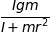

In [11]:
soln[T]

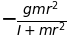

In [12]:
soln[a]

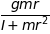

In [13]:
soln[alpha]


The results are

$T      = m g I / I^*   $

$a      = -m g r^2 / I^* $

$\alpha = m g r / I^*    $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.

You can also see [the derivation of these equations in this video](https://www.youtube.com/watch?v=chC7xVDKl4Q).

To simulate the system, we don't really need $T$; we can plug $a$ and $\alpha$ directly into the slope function.

In [14]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

**Exercise:**  Simulate the descent of a yo-yo.  How long does it take to reach the end of the string?

I provide a `Params` object with the system parameters:

* `Rmin` is the radius of the axle.  `Rmax` is the radius of the axle plus rolled string.

* `Rout` is the radius of the yo-yo body.  `mass` is the total mass of the yo-yo, ignoring the string.  

* `L` is the length of the string.

* `g` is the acceleration of gravity.

In [15]:
params = Params(Rmin = 8e-3 * m,
                Rmax = 16e-3 * m,
                Rout = 35e-3 * m,
                mass = 50e-3 * kg,
                L = 1 * m,
                g = 9.8 * m / s**2,
                t_end = 1 * s)

Here's a `make_system` function that computes `I` and `k` based on the system parameters.

I estimated `I` by modeling the yo-yo as a solid cylinder with uniform density ([see here](https://en.wikipedia.org/wiki/List_of_moments_of_inertia)).

In reality, the distribution of weight in a yo-yo is often designed to achieve desired effects.  But we'll keep it simple.

In [16]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, Rout, 
                              mass, L, g, t_end
    
    returns: System with init, k, Rmin, Rmax, mass,
                         I, g, ts
    """
    L, mass = params.L, params.mass
    Rout, Rmax, Rmin = params.Rout, params.Rmax, params.Rmin 
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L,
                 v = 0 * m / s)
    
    I = mass * Rout**2 / 2
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    
    return System(params, init=init, I=I, k=k)

Testing `make_system`

In [17]:
system = make_system(params)

In [18]:
system.init

,values
theta,0 radian
omega,0.0 radian / second
y,1 meter
v,0.0 meter / second


Write a slope function for this system, using these results from the book:

$ r = \sqrt{2 k y + R_{min}^2} $ 

$ T      = m g I / I^*  $

$ a      = -m g r^2 / I^* $

$ \alpha  = m g r / I^*  $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.


**The classical mechanics of a yo-yo is a function of torque and force.**

**It can also be described as a function of tension T and mass**

**The video listed above is very helpful.**

In [19]:
def slope_func(state, t, system):

    theta, omega, y, v = state
    
    
    # y and L are both Length
    
    # k is .00096 meters/radian
    #    its the "radious diff" of the donut of the string divided by Length of string and radians
    
    
    # g is the gravitational contant
    
    
    g, k, Rmin = system.g, system.k, system.Rmin
    I, mass = system.I, system.mass
    
    
    # reproduce the 1st
    r = sqrt(2*k*y + Rmin**2)
    alpha = mass * g * r / (I + mass * r**2)
    a = -r * alpha
   #  print("t = ", t, " y = ", y, " alpha = ", alpha, " r = ", r )    

    return omega, alpha, v, a 

Test your slope function with the initial paramss.

In [21]:
slope_func(system.init,0*s,system)

(0.0 radian/second,
 180.54116292458264 1/radian⁰⋅⁵/second²,
 0.0 meter/second,
 -2.888658606793322 meter/radian/second²)

Write an event function that will stop the simulation when `y` is 0.

In [22]:
def event_func(state, t, system):
# y starts as length but gets smaller as the yo yo drops
    theta, omega, y, v = state
    return y

Test your event function:

In [23]:
event_func(system.init, 0*s, system)

1 meter

Then run the simulation.

In [24]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.05)
details

,values
success,True
message,A termination event occurred.


Check the final state.  If things have gone according to plan, the final value of `y` should be close to 0.

In [25]:
display(results)

,theta,omega,y,v
0.00000,0 radian,0.0 radian / second,1 meter,0.0 meter / second
0.01000,0.009027058146229132 radian,1.8054116292458264 radian / second,0.9998555670696604 meter,-0.028886586067933224 meter / second
0.02000,0.03610803187170412 radian,3.6107429640351385 radian / second,0.9994222793129175 meter,-0.05776875826100397 meter / second
0.03000,0.08124171658491272 radian,5.415913623442199 radian / second,0.9987002029404574 meter,-0.0866421014952915 meter / second
0.04000,0.14442610326920963 radian,7.220843062232119 radian / second,0.9976894483214327 meter,-0.1155021986526808 meter / second
...,...,...,...,...
0.84000,61.535641480178484 radian,139.88374766222944 radian / second,0.07741605098224841 meter,-1.95457868789444 meter / second
0.85000,62.94077298185786 radian,141.13083075196482 radian / second,0.057814369800615766 meter,-1.9655210557907246 meter / second
0.86000,64.35825691544625 radian,142.35365189065445 radian / second,0.0381056409810772 meter,-1.975984271354837 meter / second
0.87000,65.78784476651106 radian,143.5509865731597 radian / second,0.01829469539155358 meter,-1.985960437473269 meter / second


Plot the results.

`theta` should increase and accelerate.

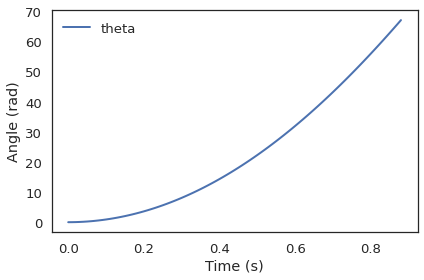

In [26]:
def plot_theta(results):
    plot(results.theta, color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
plot_theta(results)

`y` should decrease and accelerate down.

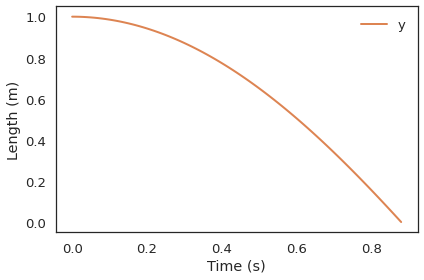

In [27]:
def plot_y(results):
    plot(results.y, color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Plot velocity as a function of time; is the yo-yo accelerating?

*No its decelerating*

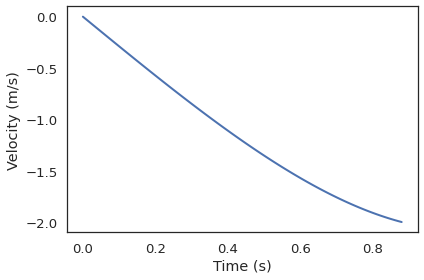

In [29]:
v = results.v # m / s
plot(v)
decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Use `gradient` to estimate the derivative of `v`.  How does the acceleration of the yo-yo compare to `g`?

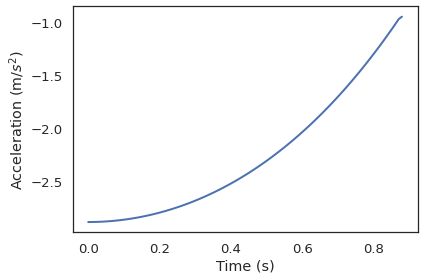

In [30]:
a = gradient(v)
plot(a)
decorate(xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)')

*For the concept of I or moment of Inertia, you can see [this wikepedia page](https://en.wikipedia.org/wiki/List_of_moments_of_inertia).*

*For the concept of Torque, see [this wikepedia page](https://en.wikipedia.org/wiki/Torque).*